In [2]:
import torchvision

In [14]:

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import random
import matplotlib.patches as patches
import os

from torchvision.io import read_image
import torch
import torchvision
from torchvision import transforms
from torchvision import ops
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

DEFAULT_IMG_PATH = "data/images"
DEFAULT_ANNOTATION_PATH = "data/annotation_txts"

def parse_path(img_path, annotation_path):
    # List all files in the given directory
    file_names = os.listdir(img_path)
    
    # Filter out non-image files and remove extensions, assuming images end with typical image file extensions
    image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff'}
    path_images = [f"{img_path}/{file_name}" for file_name in file_names]
    image_filenames_no_ext = [os.path.splitext(file)[0] for file in file_names if os.path.splitext(file)[1].lower() in image_extensions]
    assert len(image_filenames_no_ext) == len(path_images)
    path_annotations = [f"{annotation_path}/{file_name}.txt" for file_name in image_filenames_no_ext]
    return path_images, path_annotations

def parse_annotation(annotation_path):
    boxes = []
    labels = []
    with open(annotation_path, 'r') as file:
            for line in file:
                data = line.strip().split()
                class_label = int(data[0])
                class_label = 0 # the class in the text file is wrong

                # Convert coordinates to [x_min, y_min, x_max, y_max]
                x_min = float(data[1])
                y_min = float(data[2])
                x_max = float(data[3])
                y_max = float(data[4])
                boxes.append([x_min, y_min, x_max, y_max])
                labels.append(class_label)
    return torch.as_tensor(boxes, dtype=torch.float32), torch.as_tensor(labels, dtype=torch.int64)

class BoarDatasetVis(Dataset):
    '''
    A Pytorch Dataset class to load the images and their corresponding annotations.
    
    Returns
    ------------
    images: torch.Tensor of size (B, C, H, W)
    gt bboxes: torch.Tensor of size (B, max_objects, 4)
    gt classes: torch.Tensor of size (B, max_objects)
    '''
    def __init__(self, img_path=DEFAULT_IMG_PATH, annotation_path=DEFAULT_ANNOTATION_PATH, transform=None):
        self.annotation_path = annotation_path
        self.img_path = img_path
        self.transform = transforms.Compose([
            transforms.ToTensor(), 
            # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        self.imgs, self.boxes, self.labels = self.get_data()
        
    def __len__(self):
        return self.imgs.size(dim=0)
    
    def __getitem__(self, idx):
        return self.imgs[idx], self.boxes[idx], self.labels[idx]
        
    def get_data(self):
        imgs = []
        classes = []
        boxes = []
        path_images, path_annotations = parse_path(img_path=self.img_path, annotation_path=self.annotation_path)
        for img_path, annotation_path in zip(path_images, path_annotations):

            img = Image.open(img_path).convert("RGB")
            if self.transform:
                img = self.transform(img)
            boxes_tensor, labels_tensor = parse_annotation(annotation_path)
            imgs.append(img)
            boxes.append(boxes_tensor)
            classes.append(labels_tensor)
        
        imgs = torch.stack(imgs, dim=0)
        # boxes = pad_sequence(boxes, batch_first=True, padding_value=0)
        # classes = pad_sequence(classes, batch_first=True, padding_value=0)  # Use -1 for classes padding if it is a safe 'ignore' index

        return imgs, boxes, classes

In [15]:
# from dataset import BoarDataset
dataset = BoarDatasetVis()


#### Double checking if the dataset outputs correct boxes

In [16]:
dataset[0][0]

tensor([[[0.2314, 0.1608, 0.0902,  ..., 0.3294, 0.5686, 0.6941],
         [0.3647, 0.2471, 0.1529,  ..., 0.3059, 0.4941, 0.6471],
         [0.4314, 0.3333, 0.2667,  ..., 0.2353, 0.3216, 0.4745],
         ...,
         [0.6039, 0.5529, 0.5804,  ..., 0.5804, 0.6000, 0.6784],
         [0.6510, 0.6157, 0.6275,  ..., 0.6824, 0.6706, 0.6824],
         [0.5882, 0.6275, 0.6353,  ..., 0.6588, 0.6431, 0.6275]],

        [[0.2471, 0.1765, 0.1059,  ..., 0.3804, 0.6157, 0.7412],
         [0.3804, 0.2627, 0.1686,  ..., 0.3569, 0.5412, 0.6941],
         [0.4510, 0.3529, 0.2863,  ..., 0.2863, 0.3608, 0.5137],
         ...,
         [0.6000, 0.5490, 0.5765,  ..., 0.5529, 0.5725, 0.6510],
         [0.6471, 0.6118, 0.6235,  ..., 0.6471, 0.6392, 0.6510],
         [0.5843, 0.6235, 0.6314,  ..., 0.6235, 0.6118, 0.5961]],

        [[0.2510, 0.1804, 0.1098,  ..., 0.2627, 0.5216, 0.6627],
         [0.3843, 0.2667, 0.1725,  ..., 0.2392, 0.4471, 0.6078],
         [0.4627, 0.3647, 0.2980,  ..., 0.1686, 0.2627, 0.

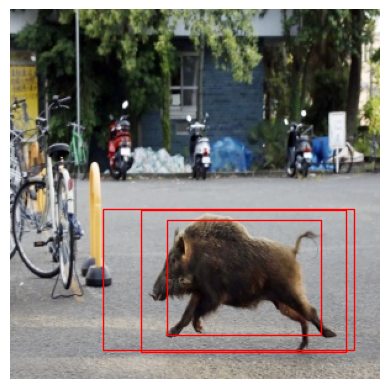

In [17]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision.transforms.functional as F
import torch
from dataset import BoarDataset  # Make sure to import your dataset class

def show_image_with_boxes(img_tensor, boxes_tensor, ax=None):
    """
    Display an image with bounding boxes.
    
    Parameters:
    - img_tensor: Tensor of the image data with pixel values in [0, 1].
    - boxes_tensor: Tensor of bounding boxes, each defined as [x_min, y_min, x_max, y_max].
    - ax: Matplotlib Axes object for plotting. If None, creates a new figure.
    """
    # Create a matplotlib figure and axis if none are provided
    if ax is None:
        fig, ax = plt.subplots(1)
    
    # Convert the image tensor to a PIL image (assuming it's in CxHxW format)
    img = F.to_pil_image(img_tensor)

    # Display the image
    ax.imshow(img)

    # Add the bounding boxes
    for box in boxes_tensor:
        x_min, y_min, x_max, y_max = box
        # Create a Rectangle patch
        rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, edgecolor='r', facecolor='none')
        # Add the patch to the Axes
        ax.add_patch(rect)
    
    # Remove axis details
    ax.axis('off')

# Example usage:
# Assuming dataset is an instance of BoarDataset and has at least one image loaded.
# dataset = BoarDataset()
img, boxes, _ = dataset[0]  # Get the first image and its boxes
# pred_boxes = [[126.8480, 170.6379, 251.9388, 263.5575],
#         [105.5562, 162.1955, 272.3223, 277.7397],
#         [ 75.3411, 161.7917, 278.6782, 276.3635]]
pred_boxes = [[156.9072, 160.9988, 251.3434, 258.1598]]
show_image_with_boxes(img, pred_boxes)
plt.show()


In [25]:
pred_boxes, boxes

(tensor([105.5562, 162.1955, 272.3223, 277.7397]),
 tensor([[104., 152., 272., 283.]]))

In [18]:
from dataset import BoarDataset
dataset = BoarDataset()
dataset[0]

(tensor([[[-1.1075, -1.4158, -1.7240,  ..., -0.6794,  0.3652,  0.9132],
          [-0.5253, -1.0390, -1.4500,  ..., -0.7822,  0.0398,  0.7077],
          [-0.2342, -0.6623, -0.9534,  ..., -1.0904, -0.7137, -0.0458],
          ...,
          [ 0.5193,  0.2967,  0.4166,  ...,  0.4166,  0.5022,  0.8447],
          [ 0.7248,  0.5707,  0.6221,  ...,  0.8618,  0.8104,  0.8618],
          [ 0.4508,  0.6221,  0.6563,  ...,  0.7591,  0.6906,  0.6221]],
 
         [[-0.9328, -1.2479, -1.5630,  ..., -0.3375,  0.7129,  1.2731],
          [-0.3375, -0.8627, -1.2829,  ..., -0.4426,  0.3803,  1.0630],
          [-0.0224, -0.4601, -0.7577,  ..., -0.7577, -0.4251,  0.2577],
          ...,
          [ 0.6429,  0.4153,  0.5378,  ...,  0.4328,  0.5203,  0.8704],
          [ 0.8529,  0.6954,  0.7479,  ...,  0.8529,  0.8179,  0.8704],
          [ 0.5728,  0.7479,  0.7829,  ...,  0.7479,  0.6954,  0.6254]],
 
         [[-0.6890, -1.0027, -1.3164,  ..., -0.6367,  0.5136,  1.1411],
          [-0.0964, -0.6193,

In [25]:
import torch
from torchvision import transforms, models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image
import os

# Ensure MPS is available and set it as the default device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

# Load the pre-trained Faster R-CNN model
model = models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=True)
model.to(device)
model.eval()

# Custom transformation and dataset class
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.images = os.listdir(image_dir)
        self.transform = transform if transform else transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

# Assuming your images are in the 'path/to/your/images' directory
# dataset = CustomDataset('/path/to/your/images')

# Load the first image and perform a forward pass
first_image = dataset[2][0].to(device)
with torch.no_grad():
    prediction = model([first_image])  # The model expects a batch, thus [first_image]

# Output the prediction
print(prediction)


Using device: mps
[{'boxes': tensor([[156.9072, 160.9988, 251.3434, 258.1598]], device='mps:0'), 'labels': tensor([28], device='mps:0'), 'scores': tensor([0.0576], device='mps:0')}]
